## Imports

In [1]:
import copy
import glob
import importlib
import itertools
import math
import os
import random
import shutil
import sys
from math import degrees, pi, radians
from os.path import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import SimpleITK as sitk
import skimage.feature as skf
from skimage.morphology import ball
import seaborn as sns
import cnn_builder as cbuild
import config
import lipiodol_methods as lm
import lipiodol_analysis as lan
import lipiodol_vis as lvis
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
import niftiutils.visualization as vis
import skimage.filters as filters
from config import Config
sns.set(style="ticks")
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
importlib.reload(config)
C = config.Config()
target_dir = "D:\\Lipiodol\\Data"
lesions = [basename(fn) for fn in glob.glob(join(target_dir,"*"))]
num_lesions = len(lesions)
liplvls = [0, 87, 155, 241]

## Pattern analysis

In [ ]:
importlib.reload(lm)
for fn in lesions:
    lesion_id = basename(fn)
    P = lm.get_paths_dict(lesion_id, target_dir)
    #lm.reg_to_ct24(lesion_id, target_dir)

### Validate HU scale

In [11]:
ct_img, D = hf.dcm_load(join(target_dir, lesion_id, "CT24h"))
hf.save_nii(ct_img, P['ct24']['img'], D)

In [17]:
LI = {}
for lesion_id in lesions:
    P = lm.get_paths_dict(lesion_id, target_dir)
    M = masks.get_mask(P['ct24']['tumor'], img_path=P['ct24']['img'], overlaid=True)
    if (M > liplvls[1]).sum() != 0:
        LI[lesion_id] = filters.threshold_otsu(M[M > liplvls[1]])

In [18]:
hf.pickle_dump(LI, "D:\\li-thresholds.bin")

In [ ]:
LI = hf.pickle_load("D:\\li-thresholds.bin")

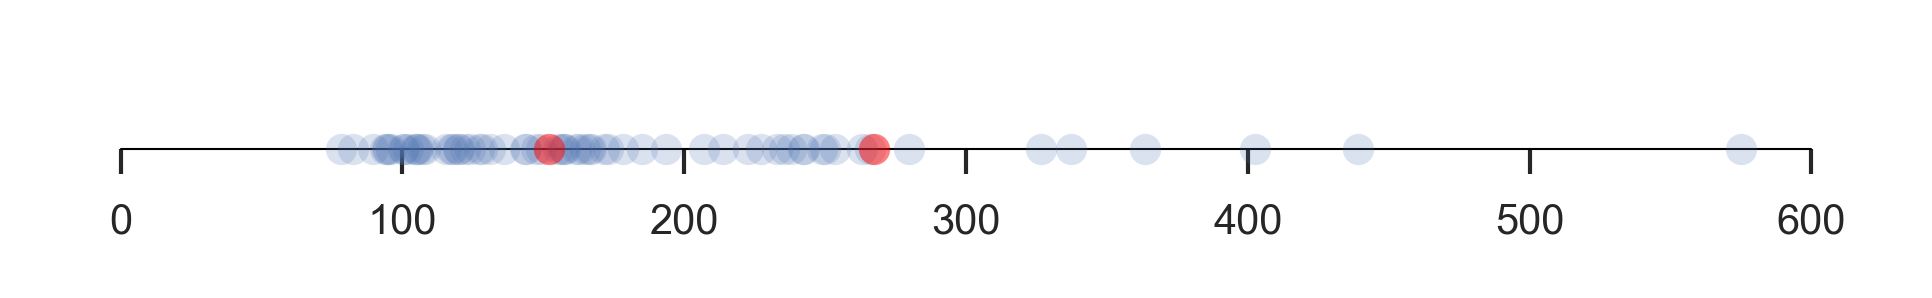

In [43]:
plt.figure(figsize=(8, 1), dpi=300)
plt.plot(np.linspace(0,600,100), [0]*100, 'k-', lw=.5)
plt.plot(list(LI.values()), np.zeros(len(LI)), '.', markersize=15, alpha=.2)
plt.plot([151.9,267.2], [0,0], 'r.', markersize=15, alpha=.5)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.yticks([]);
plt.axes().spines['bottom'].set_position('center')

In [42]:
lesion_id = 'BM-09'
P = lm.get_paths_dict(lesion_id, target_dir)
img,D = hf.nii_load(P['ct24']['img'])
M = masks.get_mask(P['ct24']['tumor'], D, img.shape)[0]
img = img*M/M.max()

In [34]:
importlib.reload(masks)
masks.create_mask_from_threshold(img, D, filters.threshold_li(img[img > 75]),
                         high_mask_path="D:\\high_mask_bm09", primary_mask_path=P['ct24']['tumor'])

In [41]:
filters.threshold_isodata(img[img > 75])

267.2265625

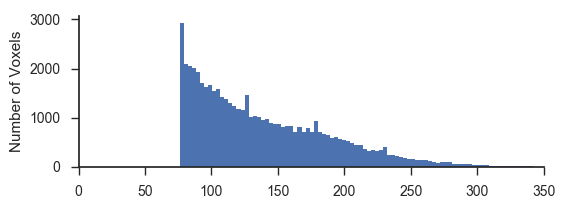

In [49]:
plt.figure(figsize=(6,2), dpi=100)
plt.hist(img[img > 75].flatten(), 100);#, color='r');
#plt.xlabel('Intensity (Hounsfield units)')
plt.xlim([0,350])
#plt.ylim([0,1500])
plt.ylabel('Number of Voxels')
sns.despine(top=True, right=True)

In [25]:
np.percentile(list(O.values()), 100/3), np.percentile(list(O.values()), 200/3)

(151.033203125, 243.12109375000009)

In [22]:
np.percentile(list(LI.values()), 100/3), np.percentile(list(LI.values()), 200/3)

(158.79102482992081, 238.7200039559966)

In [26]:
np.mean([151.033203125,158.79102482992081]), np.mean([238.7200039559966,243.12109375000009])

(154.91211397746042, 240.92054885299834)

### Build DataFrame

In [28]:
pattern_feat_cols = ["lipcoverage_vol", "high_lip", "rim_lipiodol", "low_peripheral", "mid_peripheral"]
pattern_df = pd.DataFrame(columns=pattern_feat_cols)

for name in lipresp_cols:
    df.loc[:,"peripheral_coverage%"]=pd.Series(np.random.randn(len(df)), index=df.index)

In [31]:
pattern_df = pd.read_excel(C.data_xls_path, "Patterns")
vasc_depo_df = pd.read_excel(C.data_xls_path, "Perfusion-Deposition Data")
depo_resp_df = pd.read_excel(C.data_xls_path, "Deposition-Response Data")

In [4]:
writer = pd.ExcelWriter(C.data_xls_path)

### Get Patterns

In [ ]:
importlib.reload(lan)
diams={}
for lesion_id in lesions:
    print(lesion_id)
    diams[lesion_id] = lan.get_RECIST(lm.get_paths_dict(lesion_id, target_dir))
    pattern_df.loc[lesion_id, "diameter"] = diams[lesion_id]

np.mean(list(map(float,diams.values()))), np.std(list(map(float,diams.values())))

In [59]:
importlib.reload(lan)

<module 'lipiodol_analysis' from 'C:\\Users\\Clinton\\Documents\\Lipiodol\\lipiodol_analysis.py'>

In [ ]:
importlib.reload(lan)
for lesion_id in lesions:
    print(lesion_id)
    pattern_df.loc[lesion_id][:5] = lan.get_row_entry(lesion_id, target_dir, liplvls)

In [ ]:
importlib.reload(lan)
for lesion_id in lesions:
    print(lesion_id)
    #pattern_df.loc[lesion_id, ['lipcoverage_vol', 'high_lip']] = lm.get_vol_coverage(lesion_id, target_dir)
    pattern_df.loc[lesion_id, "rim_lipiodol"] = lan.get_rim_coverage(lesion_id, target_dir, liplvls[1])
    #pattern_df.loc[lesion_id, ["low_peripheral", "mid_peripheral"]] = \
    #        lan.get_peripheral_coverage(lesion_id, target_dir, liplvls[1:3])

In [37]:
importlib.reload(lan)
lesion_id = "PK-23B"
pattern_df.loc[lesion_id][:5] = lan.get_row_entry(lesion_id, target_dir, liplvls)
#pattern_df.loc[lesion_id, "rim_lipiodol"] = lan.get_rim_coverage(lesion_id, target_dir, liplvls[1])

In [68]:
importlib.reload(lan)
lan.validate_patterns(pattern_df)

0.5092155361865541


exemplars = [x.upper() for x in ["Pk-01a","Pk-03","Pk-08","Pk-11c","Bm-07","Bm-16a","Bm-16b","Bm-19","Bm-21","Bm-24","Bm-25","Bm-37"]]

In [6]:
importlib.reload(lan)
lan.get_counts(master_df)

I_df 13
I_R_df 0
I_H_df 0
I_S_df 9
H_df 10
RS_df 8
nRS_df 11
RnS_df 6
nRnS_df 17


In [38]:
master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
master_df = master_df.join(pattern_df)
modality = "ct24"

master_df["lipcoverage_vol"] = master_df["lipcoverage_vol"].astype(float)
master_df["high_lip"] = master_df["high_lip"].astype(float)
master_df["rim_lipiodol"] = master_df["rim_lipiodol"].astype(float)
master_df["low_peripheral"] = master_df["low_peripheral"].astype(float)
master_df["mid_peripheral"] = master_df["mid_peripheral"].astype(float)

In [37]:
ixs = master_df['selective=0']==1
master_df.loc[ixs,"diameter"].values.mean(), master_df.loc[ixs,"diameter"].values.std()

(53.25277463465104, 46.20693977759877)

lesion_id = "PK-11C"
pattern_df.loc[lesion_id] = lm.get_row_entry(lesion_id, target_dir)

importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    lips = lm.enhancing_to_nec(lesion_id, target_dir, liplvls)
    lipresp_df.loc[ix] = np.round(np.array(lips)*100,2).flatten()

In [86]:
writer = pd.ExcelWriter(C.data_xls_path)
pattern_df.to_excel(writer, "Patterns")
vasc_depo_df.to_excel(writer, "Perfusion-Deposition Data")
depo_resp_df.to_excel(writer, "Deposition-Response Data")
writer.save()

## Correlating Vasc/Lip Deposition

In [82]:
importlib.reload(lan)
vasc_depo_df = pd.DataFrame(columns=np.transpose([[str(L)+"N", str(L)+"V", str(L)+"A"] for L in liplvls], (1,0)).flatten())
for lesion_id in lesions:
    vasc_depo_df.loc[lesion_id] = lan.vascular_to_deposition(lesion_id, target_dir, liplvls, exclude_small=True)

In [43]:
importlib.reload(lan)
depo_resp_df = pd.DataFrame(columns=liplvls+["qEASL"])
for lesion_id in lesions:
    depo_resp_df.loc[lesion_id] = lan.lip_to_response(lesion_id, target_dir, liplvls, exclude_small=True)

In [26]:
lesion_id="BM-20B"
depo_resp_df.loc[lesion_id] = lan.lip_to_response(lesion_id, target_dir, liplvls, exclude_small=True)

In [73]:
Vdf = vasc_depo_df.dropna()
Rdf = depo_resp_df.dropna()#subset=[100,150,200])

In [ ]:
#plt.plot(depo_resp_df["Avg"].dropna().values, '.')

In [ ]:
len(Rdf.loc[(master_df['lipcoverage_vol']>.2) & (master_df['lipcoverage_vol']<.8) & (master_df["rim_lipiodol"]>.5)])

In [ ]:
sparseRdf = depo_resp_df.dropna(subset=liplvls[:1])
sparseRdf.loc[(master_df['lipcoverage_vol']<.2) & (master_df["rim_lipiodol"]<.5)]
sparseRdf.loc[(master_df['lipcoverage_vol']<.2) & (master_df["rim_lipiodol"]<.5), liplvls[1:]] = np.nan
sparseRdf.loc[(master_df['lipcoverage_vol']<.2) & (master_df["rim_lipiodol"]>=.5), liplvls[3:]] = np.nan
sparseRdf.loc["BM-28B"] = np.nan

In [ ]:
Rdf.loc[(master_df['lipcoverage_vol']>.2) & (master_df["rim_lipiodol"]<.5)]

In [ ]:
homoRdf = depo_resp_df.dropna(subset=liplvls[2:3])
homoRdf.loc[master_df["lipcoverage_vol"] > .8]

In [92]:
homoRdf.loc[master_df["lipcoverage_vol"] > .8, liplvls[:2]] = np.nan

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
((master_df["lipcoverage_vol%"] < .2) & (master_df["rim_lipiodol%"] <= .9) & (master_df["0=well delineated, 1=infiltrative"] == 1)).sum()

In [156]:
writer = pd.ExcelWriter(C.data_xls_path)
pattern_df.to_excel(writer, "Patterns")
vasc_depo_df.to_excel(writer, "Perfusion-Deposition Data")
depo_resp_df.to_excel(writer, "Deposition-Response Data")
writer.save()

## Vascularization subgraphs

In [95]:
df = pd.DataFrame(columns=["Any Coverage", "Low-Mid Coverage", "Low Coverage", "Lesion_id", "Tissue Type",
                       "Tumor Growth", "Tumor Type", "TACE Type"])

master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
master_df = master_df.join(pattern_df)
modality = "mrbl"
#master_df = master_df.join(Vdf, how='inner')

In [96]:
def get_row(row, char):
    return [row["%d%s"%(liplvls[1],char)],
            row["%d%s"%(liplvls[1],char)] - row["%d%s"%(liplvls[3],char)],
            row["%d%s"%(liplvls[1],char)] - row["%d%s"%(liplvls[2],char)]]

In [31]:
importlib.reload(lvis)
ix = 0
for lesion_id, row in Vdf.iterrows():
    const = lvis.get_df_entry(lesion_id, master_df, modality)
    
    df.loc[ix] = get_row(row,"N") + [lesion_id, "Necrosis"] + const
    df.loc[ix+1] = get_row(row,"V") + [lesion_id, "Viable"] + const
    ix += 2

In [32]:
def set_g_bar(g, save_path):
    g.set(yticks=[0.,.2,.4,.6,.8,1.], ylim=(0.,1.));
    
    for gax in g.axes[0]:
        gax.set_xlabel("")
        gax.set_ylabel("")
        #gax.tick_params('x',width=0)
        gax.set_xticks([], minor=False)
        gax.set_yticks([], minor=False)
        plt.setp(gax.patches, linewidth=1, edgecolor='k')
        
    g.set_titles(visible=False)
    #g.axes[0][0].set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"]);
    
    sns.despine(top=True, right=True, left=True)
    g.fig.subplots_adjust(left=.2, top=.95)
    
    #g.fig.tight_layout(w_pad=1)
    #plt.setp(g.ax.lines,linewidth=1);
    g.fig.savefig(save_path, width=5, dpi=150, pad_inches=0, transparent=True)
    plt.close()

In [33]:
kwargs = {"x":"Tissue Type", "data":df, "size":3, "aspect":.8, "kind":"bar", "ci":None, "legend":False}

In [34]:
g1 = sns.factorplot(y="Any Coverage", color="#D3D3D3", **kwargs)
set_g_bar(g1, join(C.fig_dir, "Vascularization figures", "Mean1.png"))
g2 = sns.factorplot(y="Low-Mid Coverage", color="#939393", **kwargs)
set_g_bar(g2, join(C.fig_dir, "Vascularization figures", "Mean2.png"))
g3 = sns.factorplot(y="Low Coverage", color="#333333", **kwargs)
set_g_bar(g3, join(C.fig_dir, "Vascularization figures", "Mean3.png"))

for category, order in [("Tumor Growth", None), ("Tumor Type", None),
                        ("TACE Type", ["Selective", "Lobar"])]:
    order = lan.get_actual_order(category, df, order)
    g1 = sns.factorplot(y="Any Coverage", col=category, color="#D3D3D3", col_order=order, **kwargs)
    set_g_bar(g1, join(C.fig_dir, "Vascularization figures", "%s1.png" % category))
    g2 = sns.factorplot(y="Low-Mid Coverage", col=category, color="#939393", col_order=order, **kwargs)
    set_g_bar(g2, join(C.fig_dir, "Vascularization figures", "%s2.png" % category))
    g3 = sns.factorplot(y="Low Coverage", col=category, color="#333333", col_order=order, **kwargs)
    set_g_bar(g3, join(C.fig_dir, "Vascularization figures", "%s3.png" % category))

focal_df = df.dropna(subset=["Tumor Growth"])
focal_df = focal_df[focal_df["Tumor Growth"].str.contains("Focal")]
for ix, row in focal_df.iterrows():
    focal_df.loc[ix, "Tumor Type"] = lvis.check_column(row["Lesion_id"], master_df, "HCC(0), ICC(1), other(2)", 
                                                  {0: "HCCs", 1: "ICCs", 2: "Metastases"}, "Focal")
    focal_df.loc[ix, "Sparsity"] = lvis.check_sparse(row["Lesion_id"], master_df, modality, "Focal")
kwargs["data"] = focal_df

for category, order in [("Homogeneity", ["Homo", "Hetero"]),# ("Sparsity", ["Sparse", "Non"]),
                        ("Rim Presence", ["Rim", "Non"])]:
    
    order = lan.get_actual_order(category, focal_df, order)
    g1 = sns.factorplot(y="Any Coverage", col=category, color="#D3D3D3", col_order=order, **kwargs)
    set_g_bar(g1, join(C.fig_dir, "Vascularization figures", "Focal_%s1.png" % category))
    g2 = sns.factorplot(y="Low-Mid Coverage", col=category, color="#939393", col_order=order, **kwargs)
    set_g_bar(g2, join(C.fig_dir, "Vascularization figures", "Focal_%s2.png" % category))
    g3 = sns.factorplot(y="Low Coverage", col=category, color="#333333", col_order=order, **kwargs)
    set_g_bar(g3, join(C.fig_dir, "Vascularization figures", "Focal_%s3.png" % category))

infil_df = df.dropna(subset=["Tumor Growth"])
infil_df = infil_df[infil_df["Tumor Growth"].str.contains("Infiltrative")]
for ix, row in infil_df.iterrows():
    infil_df.loc[ix, "Tumor Type"] = lvis.check_column(row["Lesion_id"], master_df, "HCC(0), ICC(1), other(2)", 
                                                  {0: "HCCs", 1: "ICCs", 2: "Metastases"}, "Infiltrative")
    infil_df.loc[ix, "Sparsity"] = lvis.check_sparse(row["Lesion_id"], master_df, modality, "Infiltrative")
kwargs["data"] = infil_df

for category, order in [("Tumor Type", None), ("TACE Type", ["Selective", "Lobar"]), ("Sparsity", ["Sparse", "Non"])]:
    
    order = lm.get_actual_order(category, infil_df, order)
    g1 = sns.factorplot(y="Any Coverage", col=category, color="#D3D3D3", col_order=order, **kwargs)
    set_g_bar(g1, join(C.fig_dir, "Vascularization figures", "Infil_%s1.png" % category))
    g2 = sns.factorplot(y="Low-Mid Coverage", col=category, color="#939393", col_order=order, **kwargs)
    set_g_bar(g2, join(C.fig_dir, "Vascularization figures", "Infil_%s2.png" % category))
    g3 = sns.factorplot(y="Low Coverage", col=category, color="#333333", col_order=order, **kwargs)
    set_g_bar(g3, join(C.fig_dir, "Vascularization figures", "Infil_%s3.png" % category))

## Response subgraphs

In [75]:
master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
master_df = master_df.join(pattern_df)
modality = "ct24"

master_df["lipcoverage_vol"] = master_df["lipcoverage_vol"].astype(float)
master_df["high_lip"] = master_df["high_lip"].astype(float)
master_df["rim_lipiodol"] = master_df["rim_lipiodol"].astype(float)
master_df["low_peripheral"] = master_df["low_peripheral"].astype(float)
master_df["mid_peripheral"] = master_df["mid_peripheral"].astype(float)

#master_df = master_df.join(Rdf, how='inner')

### qEASL vs peripheral deposition

importlib.reload(lan)
for lesion_id in lesions:#master_df.iterrows():
    #print(lesion_id)
    master_df.loc[lesion_id, "qEASL"] = lan.get_qEASL(lesion_id, target_dir)

master_df = master_df[master_df['selective=0']==0]

In [99]:
master_df["low_peripheral"] = master_df["low_peripheral"].astype(float)
master_df["mid_peripheral"] = master_df["mid_peripheral"].astype(float)

In [ ]:
master_df.sort_values("qEASL",ascending=False)["qEASL"]

In [ ]:
master_df.sort_values("low_peripheral")[["low_peripheral","qEASL"]]

In [125]:
master_df.columns

Index(['0=well delineated, 1=infiltrative', 'HCC(0), ICC(1), other(2)',
       'selective=0', 'qEASL 30d', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8', '0=well delineated, 1=infiltrative.1',
       'HCC(0), ICC(1), other(2).1', 'selective=0.1', 'homogenous=0',
       'peripheral', 'sparse', 'rim', 'Unnamed: 16', 'Unnamed: 17',
       'RECIST 30d', 'mRECIST 30d', 'qEASL(%) 30d', 'Unnamed: 21', 'Pat#',
       'CBCT E#', 'lipcoverage_vol', 'high_lip', 'rim_lipiodol',
       'low_peripheral', 'mid_peripheral', 'diameter', 'qEASL'],
      dtype='object')

In [129]:
np.nanmean(master_df.loc[master_df['selective=0']==0,"low_peripheral"])

0.5348177316501194

In [ ]:
g=sns.regplot(x=master_df.dropna(subset=["qEASL"]).loc[master_df['selective=0']==0,"low_peripheral"],
              y=master_df.dropna(subset=["qEASL"]).loc[master_df['selective=0']==0,"qEASL"], ci=None)
g.set_ylabel("Change in Viable Tumor Volume")
g.set_xlabel("Peripheral Coverage")
g.set_ylim([-1,.5]);
g.set_yticks([-1,-.5,0,.5]);
g.set_yticklabels(["-100%","-50%","0%","50%"]);
g.set_xticks([0,.2,.4,.6,.8,1.]);
g.set_xticklabels(["0%","20%", "40%", "60%", "80%", "100%"]);
plt.plot(np.linspace(0,100,1000), [-.65]*1000, 'k--', lw=.3)
plt.plot(np.linspace(0,100,1000), [.73]*1000, 'k--', lw=.3)
sns.despine(top=True, right=True)

In [105]:
scipy.stats.linregress(master_df.dropna(subset=["qEASL"]).loc[master_df['selective=0']==0,"low_peripheral"],
                       master_df.dropna(subset=["qEASL"]).loc[master_df['selective=0']==0,"qEASL"])

LinregressResult(slope=-0.5969762348470661, intercept=-0.32600490090880385, rvalue=-0.4262165904598939, pvalue=0.013388210982527775, stderr=0.22756872719858146)

In [ ]:
g=sns.factorplot(x="low_peripheral", y="qEASL", hue="selective=0", data=master_df, join=False)
g.ax.set_ylabel("Change in Viable Tumor Volume")
g.ax.set_xlabel("Peripheral Coverage")
g.ax.set_ylim([-1,2.5]);
g.ax.set_yticks([-1,0,1,2]);
g.ax.set_yticklabels(["-100%","0%","100%","200%"]);
g.ax.set_xticks([0,.2,.4,.6,.8,1.]);
g.ax.set_xticklabels(["0%","20%", "40%", "60%", "80%", "100%"]);
plt.plot(np.linspace(0,100,1000), [-.65]*1000, 'k--', lw=.3)
plt.plot(np.linspace(0,100,1000), [.73]*1000, 'k--', lw=.3)
sns.despine(top=True, right=True)

In [ ]:
g=sns.regplot(x=master_df["mid_peripheral"], y=master_df["qEASL"])
g.set_ylabel("% change in viable tumor volume")
g.set_xlabel("% peripheral coverage (150 HU)")

In [589]:
#full_df = Rdf.join(master_df)
#full_df[(full_df["lipcoverage_vol%"] < .25) & (full_df["high_lip"] < .1)]

### main analysis

In [ ]:
master_df.loc[(master_df['lipcoverage_vol']<.2), ["rim_lipiodol","qEASL"]].dropna().sort_values("rim_lipiodol")

In [94]:
df = pd.DataFrame(columns=["Response", "Lesion_id", "Lipiodol Deposition",
                       "Tumor Growth", "Tumor Type", "TACE Type", "Homogeneity", "Sparsity", "Rim Presence"])

importlib.reload(lvis)
ix = 0
for lesion_id, row in homoRdf.iterrows():
    const = lvis.get_df_entry(lesion_id, master_df, modality)
    for i in range(4):
        df.loc[ix+i] = [row[liplvls[i]], lesion_id, ["None", "Low", "Medium", "High"][i]] + const
    ix += 4

In [95]:
kwargs = {"x":"Lipiodol Deposition", "y":"Response", "data":df, "size":3, "ci":None,
          "markers":["s", "o", "^"], "legend":False}

In [96]:
def set_g(g, save_path):
    g.set(yticks=[0,.2,.4,.6,.8,1.], ylim=(0.,1.));
    g.ax.set_yticklabels(["0%","20%", "40%", "60%", "80%", "100%"]);
    g.ax.set_xlabel("")
    g.ax.set_ylabel("")
    #g.ax.tick_params('y',width=0)
    #sns.despine(bottom=True)
    #g.fig.tight_layout(w_pad=1)
    plt.legend(loc='lower left');
    g.fig.subplots_adjust(left=0.2)
    #plt.setp(g.ax.lines,linewidth=1);
    g.fig.savefig(save_path, dpi=1000, pad_inches=0, transparent=True)
    plt.close()

all_df = copy.deepcopy(df)

In [79]:
for category, order in [("Tumor Growth", None), ("Tumor Type", None),
                        ("TACE Type", ["Selective", "Lobar"]), ("Sparsity", ["Sparse", "Non"])]:
    g = sns.factorplot(hue=category, hue_order=lan.get_actual_order(category, df, order), **kwargs)
    set_g(g, join(C.fig_dir, "Deposition figures", "%s.png" % category));

In [97]:
focal_df = df.dropna(subset=["Tumor Growth"])
focal_df = focal_df[focal_df["Tumor Growth"].str.contains("Well-del")]
for ix, row in focal_df.iterrows():
    focal_df.loc[ix, "Tumor Type"] = lvis.check_column(row["Lesion_id"], master_df, "HCC(0), ICC(1), other(2)", 
                                                  {0: "HCCs", 1: "ICCs", 2: "Metastases"}, "WD")
    focal_df.loc[ix, "Sparsity"] = lvis.check_sparse(row["Lesion_id"], master_df, modality, "WD")

if True:
    for category, order in [("Homogeneity", ["Homo", "Hetero"])]:
        g = sns.factorplot(hue=category, hue_order=lan.get_actual_order(category, focal_df, order), **kwargs)
        set_g(g, join(C.fig_dir, "Deposition figures", "Focal_%s.png" % category));

elif False:
    focal_df = focal_df.dropna(subset=["Sparsity"])
    kwargs["data"] = focal_df[focal_df["Sparsity"].str.startswith("Sparse")]
    for category, order in [("Rim Presence", ["Rim", "Non"])]:
        g = sns.factorplot(hue=category, hue_order=lan.get_actual_order(category, focal_df, order), **kwargs)
        set_g(g, join(C.fig_dir, "Deposition figures", "Focal_Sparse_%s.png" % category));

else:
    focal_df = focal_df.dropna(subset=["Sparsity"])
    kwargs["data"] = focal_df[focal_df["Sparsity"].str.startswith("Non")]
    for category, order in [("Rim Presence", ["Rim", "Non"])]:
        g = sns.factorplot(hue=category, hue_order=lan.get_actual_order(category, focal_df, order), **kwargs)
        set_g(g, join(C.fig_dir, "Deposition figures", "Focal_Non-Sparse_%s.png" % category));

In [145]:
len(focal_df[(focal_df["Sparsity"].str.startswith("Non")) & (focal_df["Rim Presence"].str.startswith("Rim"))])/4

8.0

In [ ]:
focal_df[focal_df["Sparsity"].str.startswith("Sparse")]

infil_df = df.dropna(subset=["Tumor Growth"])
infil_df = infil_df[infil_df["Tumor Growth"].str.contains("Infiltrative")]
for ix, row in infil_df.iterrows():
    infil_df.loc[ix, "Tumor Type"] = lvis.check_column(row["Lesion_id"], master_df, "HCC(0), ICC(1), other(2)", 
                                                  {0: "HCCs", 1: "ICCs", 2: "Metastases"}, "Infiltrative")
    infil_df.loc[ix, "Sparsity"] = lvis.check_sparse(row["Lesion_id"], master_df, modality, "Infiltrative")
kwargs["data"] = infil_df

for category, order in [("Tumor Type", None), ("TACE Type", ["Selective", "Lobar"]), ("Sparsity", ["Sparse", "Non"])]:
    g = sns.factorplot(hue=category, hue_order=lm.get_actual_order(category, infil_df, order), **kwargs)
    set_g(g, join(C.fig_dir, "Deposition figures", "Infil_%s.png" % category));

In [205]:
master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")
pattern_df = pattern_df.join(master_df)

In [ ]:
len(pattern_df[(pattern_df.lipcoverage_vol < .2) & (pattern_df.lipcoverage_vol < .8) & (pattern_df.rim_lipiodol < .5)])

In [ ]:
## print(len(Rdf))
MEAN=Rdf.mean().values

In [320]:
#well delineated
print(len(Rdf[master_df.loc[Rdf.index, "0=well delineated, 1=infiltrative"] == 0]))
FOCAL=Rdf[master_df.loc[Rdf.index, "0=well delineated, 1=infiltrative"] == 0].mean().values

23


[1-df[i].mean() for i in liplvls]

[x/(1-x) for x in [0.47604184262689564,
 0.3884550297888517,
 0.3352322775428981,
 0.2986988994268489]]

In [ ]:
[1-df[i].mean() for i in liplvls]

In [ ]:
print([df[i].mean() for i in liplvls])

print(np.nanmean(depo_resp_df[0]),
np.nanmean(depo_resp_df[100]),
np.nanmean(depo_resp_df[150]),
np.nanmean(depo_resp_df[200]))

### Ground truth patterns

In [ ]:
pattern_gtruth_df = pd.read_excel(r"D:\Lipiodol\Results\Lipiodol Patterns.xlsx", index_col=0)

In [ ]:
joint_df = pd.concat([vasc_depo_df, pattern_gtruth_df], axis=1, join='inner')

In [ ]:
joint_df.columns

In [ ]:
DF=joint_df.dropna(subset=["heterogeneous"], axis=0)
subset_df = DF.loc[DF["heterogeneous"].str.contains("yes"), liplvls+["heterogeneous"]]
#subset_df = DF.loc[DF["penumbra/margin"]!="no", liplvls+["penumbra/margin"]]
subset_df

In [ ]:
subset_df.index

In [ ]:
rim = 

RIM: "BM-07", "BM-30", "BM-32", "BM-37"
Homogeneous: "BM-18", "BM-25", "BM-39", "PK-03", "PK-06"
Heterogeneous: "BM-18", "BM-25", "BM-39", "PK-03", "PK-06"
Central deposition: 'BM-18', 'BM-23', 'BM-25', 'BM-31', 'BM-32', 'BM-39', 'PK-03', 'PK-08'
Central recess: 'BM-01', 'BM-07', 'BM-12', 'BM-19', 'BM-24', 'BM-30', 'BM-36', 'PK-02', 'PK-05'
Margin: 'BM-30', 'BM-32', 'BM-36', 'BM-37', 'BM-39', 'PK-02', 'PK-03', 'PK-05'

In [ ]:
len(['BM-01', 'BM-07', 'BM-12', 'BM-19', 'BM-24', 'BM-30', 'BM-36', 'PK-02', 'PK-05'])

In [ ]:
len(subset_df)

In [ ]:
subset_df = joint_df.loc[['BM-01', 'BM-02', 'BM-03', 'BM-05', 'BM-06', 'BM-07', 'BM-09', 'BM-10',
       'BM-12', 'BM-19', 'BM-23', 'BM-24', 'BM-26', 'BM-27', 'BM-29', 'BM-30',
       'BM-31', 'BM-32', 'BM-36', 'BM-37', 'BM-39', 'PK-02', 'PK-05', 'PK-07',
       'PK-08'], [0,1,2,3]]
subset_df

In [119]:
#subset_df.mean().values
subset_df.dropna().mean().values

array([0.49861879, 0.54283119, 0.60239339, 0.64819033])

In [47]:
print(np.mean(subset_df[150]), np.mean(subset_df[200]))

0.4725199969765699 0.7846028172462818


In [514]:
vasc_depo_df.to_excel(writer, "Vascularization-Deposition")
depo_resp_df.to_excel(writer, "Deposition-Response")
writer.save()

In [ ]:
vasc_depo_df

In [515]:
liplvls=[0,100]#,250,300]#list(range(0,401,10))

In [516]:
importlib.reload(lm)
vasc_depo_df_binary = pd.DataFrame(columns=liplvls)
for lesion_id in lipresp_df.index:
    vasc_depo_df_binary.loc[lesion_id] = lm.vascular_to_deposition(lesion_id, target_dir, liplvls, exclude_small=True)

In [517]:
depo_resp_df_binary = pd.DataFrame(columns=liplvls)
for lesion_id in lipresp_df.index:
    depo_resp_df_binary.loc[lesion_id] = lm.lip_to_response(lesion_id, target_dir, liplvls, exclude_small=False)

In [518]:
vasc_depo_df_binary.to_excel(writer, "Vasc-Depo-binary")
depo_resp_df_binary.to_excel(writer, "Depo-Resp-binary")
writer.save()

## Create Ranked DICOMs

In [155]:
importlib.reload(lvis)
lvis.write_ranked_imgs(pattern_df, target_dir, "lipcoverage_vol", "P['ct24']['img']", join(C.ranking_dir, "coverage_ranking_ct24_fresh"),
                  False, "P['ct24']['tumor']", "ct")

In [92]:
importlib.reload(lvis)
lvis.write_ranked_imgs(pattern_df, target_dir, "rim_lipiodol", "P['ct24']['img']", join(C.ranking_dir, "rim_ranking_ct24"),
                  False, "P['ct24']['tumor']", "ct")

In [ ]:
lvis.write_ranked_imgs(pattern_df, target_dir, "low_peripheral", "P['ct24']['img']", join(C.ranking_dir, "penumbra_ranking_ct24"),
                  False, "P['ct24']['tumor']", "ct")

In [141]:
masks.create_dcm_with_masks(ball_ct24_path, [ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path],
                            save_dir, overwrite=True, window="ct")

## Tumor Mask Screenshots

In [ ]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    P = lm.get_paths_dict(lesion_id, target_dir)

    lm.draw_unreg_fig(mribl_art_path, mribl_tumor_mask_path, join(C.png_dir, lesion_id, "BL MR"), 'b', 'mr')
    lm.draw_unreg_fig(mri30d_art_path, mri30d_tumor_mask_path, join(C.png_dir, lesion_id, "30d MR"), 'r', 'mr')
    lm.draw_unreg_fig(ct24_path, ct24_tumor_mask_path, join(C.png_dir, lesion_id, "24h CT"), 'g', 'ct')

In [ ]:
lm.draw_reg_fig(ball_mribl_path, ball_mribl_enh_mask_path, join(C.fig_dir, lesion_id, "MRIBL"), 'b', 'mr')
lm.draw_reg_fig(ball_mri30d_path, ball_mri30d_enh_mask_path, "D:\\Lipiodol\\Figures\\MRI30d", 'r', 'mr')
lm.draw_reg_fig(ball_ct24_path, ball_highlip_mask_path, "D:\\Lipiodol\\Figures\\Lip", 'g', 'ct')

In [ ]:
# Figure for 24h CT
img,_ = hf.nii_load(ball_ct24_path)
blmask,_ = masks.get_mask(ball_mribl_enh_mask_path)
fumask,_ = masks.get_mask(ball_mri30d_enh_mask_path)

for sl in range(img.shape[-1]//4,img.shape[-1]*3//4,img.shape[-1]//12):
    plt.close()
    plt.imshow(img[...,sl], cmap='gray', vmin=30, vmax=250)
    FU=plt.contour(fumask[:,:,sl], colors='r', alpha=.4)
    plt.contour(blmask[:,:,sl], colors='b', alpha=.4)
    plt.contourf(fumask[:,:,sl], colors=[(0,0,0,0)]*6+[(1,0,0,.2)]) #look at the length of FU.allsegs
    plt.contourf(blmask[:,:,sl], colors=[(0,0,0,0)]*6+[(0,0,1,.2)])
    plt.axis('off')
    plt.savefig("D:\\Lipiodol\\Figures\\24hCT_%d.png" % sl, dpi=100, bbox_inches='tight')

### DICOMs for HU threshold validation

In [98]:
importlib.reload(masks)
for lesion_id in lesions:
    P = lm.get_paths_dict(lesion_id, target_dir)
    masks.create_dcm_with_multimask(P["ct24"]["img"], [P["ct24"]["highlip"], P["ct24"]["midlip"], P["ct24"]["lowlip"]],
                                    join("Z:\Sophie\HU threshold validation", lesion_id), overwrite=True, padding=0, window="ct")

### Binary masks for sphering figure

In [ ]:
importlib.reload(hf)
liver_dir = join(C.fig_dir, "sphering figure", "liver binary mask")
tumor_dir = join(C.fig_dir, "sphering figure", "tumor binary mask")
if not exists(liver_dir):
    os.makedirs(liver_dir)
if not exists(tumor_dir):
    os.makedirs(tumor_dir)
                
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    paths = lm.get_paths(lesion_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, mribl_sub_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    
    if False:
        M = hf.crop_nonzero(masks.get_mask(mribl_liver_mask_path)[0], pad=5)[0]
        plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
        plt.axis('off')
        plt.savefig(join(liver_dir, "%s_BLMR.png" % lesion_id), dpi=100, bbox_inches='tight')

        M = hf.crop_nonzero(masks.get_mask(ct24_liver_mask_path)[0], pad=5)[0]
        plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
        plt.axis('off')
        plt.savefig(join(liver_dir, "%s_24hCT.png" % lesion_id), dpi=100, bbox_inches='tight')

        M = hf.crop_nonzero(masks.get_mask(mri30d_liver_mask_path)[0], pad=5)[0]
        plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
        plt.axis('off')
        plt.savefig(join(liver_dir, "%s_30dMR.png" % lesion_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mribl_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_BLMR.png" % lesion_id), dpi=100, bbox_inches='tight')
                
    M = hf.crop_nonzero(masks.get_mask(ct24_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_24hCT.png" % lesion_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mri30d_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_30dMR.png" % lesion_id), dpi=100, bbox_inches='tight')

In [ ]:
importlib.reload(hf)
liver_dir = join(C.fig_dir, "sphering figure", "liver with mask")
tumor_dir = join(C.fig_dir, "sphering figure", "tumor with mask")
if not exists(liver_dir):
    os.makedirs(liver_dir)
if not exists(tumor_dir):
    os.makedirs(tumor_dir)
                
for fn in glob.glob(join(target_dir,"*")):
    lesion_id = basename(fn)
    paths = lm.get_paths(lesion_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, mribl_sub_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    
    M = hf.crop_nonzero(masks.get_mask(mribl_liver_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(liver_dir, "%s_BLMR.png" % lesion_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(ct24_liver_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(liver_dir, "%s_24hCT.png" % lesion_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mri30d_liver_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(liver_dir, "%s_30dMR.png" % lesion_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mribl_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_BLMR.png" % lesion_id), dpi=100, bbox_inches='tight')
                
    M = hf.crop_nonzero(masks.get_mask(ct24_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_24hCT.png" % lesion_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mri30d_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_30dMR.png" % lesion_id), dpi=100, bbox_inches='tight')

In [ ]:
M = hf.crop_nonzero(masks.get_mask(ball_mask_path)[0], pad=5)[0]
plt.imshow(M[:,:,M.shape[-1]//2+40], cmap='gray')
plt.axis('off')
plt.savefig("D:\\ball.png", dpi=100, bbox_inches='tight')